In [1]:
import networkx as nx
from scipy.linalg import expm, sinm, cosm
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import osmnx as ox
from sklearn.metrics import mean_squared_error
import random
import plotly.graph_objects as go
import itertools as it
from tqdm.notebook import tqdm
from ipywidgets import FloatProgress

## Functions

In [2]:
def cosine_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =2 - 2*comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])
    return cd

def comm_angle(G, comm = None):
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)
    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    angle = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            angle[i][j] =np.degrees(np.arccos(comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])))
    return angle




def comm_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])
    return cd

def comm_geo(G, cd = None, comm = None): # adds mean flow as attribute and returns a matrix
  G_simple = nx.Graph(G)
  if cd is None:
    if comm is None:
      comm = add_comm_attr(G_simple)
    cd = comm_distance(G_simple, comm)
  dfA = nx.to_pandas_adjacency(G)
  X = (dfA*cd)
  GX = nx.from_pandas_adjacency(X, nx.DiGraph)
  dfSP = nx.to_pandas_adjacency(G)
  j = dict()
  for i in list(G.edges):
    try:
      j[i[0], i[1]] =  nx.dijkstra_path_length(GX, i[1], i[0], weight = "weight")
    except:
      j[i[0], i[1]] = 0

  # teste = pd.DataFrame.from_dict(j, orient = "index")
  # for i in teste.columns:
  #   for j in teste.columns:
  #     if np.isnan(teste[i][j]):
  #       dfSP[i][j] = 0
  #     else:
  #       dfSP[i][j] = teste[i][j]
  # nx.set_node_attributes(G, values=(dfSP.mean()).to_dict(), name="mean_flow")
  return j, cd


def add_CCC(G, comm = None, cd = None): # returns a dict with a centrality
    if cd is None:
        cd = cosine_distance(G,comm)
    d = (1/cd.sum())
    nx.set_node_attributes(G, values=d.to_dict(), name="CCC")
    return d




def add_comm_attr(G): # matrix and mean comm as attr
    # G_simple = nx.Graph(G)
    nodelist = list(G)
    A = nx.to_numpy_array(G, nodelist)

    Aexp2 = expm(A)
    mapping = dict(zip(nodelist, range(len(nodelist))))

    c = {}
    d = {}
    for u in G:
        c[u] = {}
        for v in G:
            c[u][v] = float(Aexp2[mapping[u], mapping[v]])
        d[u] = np.mean(list(c[u].values()))

    nx.set_node_attributes(G, values=d, name="comm")
    return c

def plotting(G, value, pos = None):
    groups = nx.get_node_attributes(G,value).values()
    mapping = dict(zip(count(),sorted(groups)))

    nodes = G.nodes()
    colors = [mapping[n] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    if not pos:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(10,10))
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()


def graph_folium_bg(G, n_attribute = None, e_attribute = None, cmap = "hot", poly = None):
    nodes, edges = ox.graph_to_gdfs(G)
    if poly is not None:
        m = poly.explore()
        m = edges.explore(m=m, column = e_attribute, cmap = cmap, color = "black")
    else:
        m = edges.explore(column = e_attribute, cmap = cmap, color = "black")
    m = nodes.explore(m=m, column = n_attribute, cmap = cmap, color = "black")
    return m

def calculations(G):
    flow, X = comm_geo(G)
    nx.set_edge_attributes(G, flow, "Flow of returnal")
    bet = nx.edge_betweenness_centrality(G, normalized = False)
    nx.set_edge_attributes(G, bet, "Betweenness")

    j = dict()
    for i in list(G.edges):
        try:
            j[i[0], i[1]] =  nx.dijkstra_path_length(G, i[1], i[0])
        except:
            j[i[0], i[1]] = 0

    df = pd.DataFrame(flow.values(), columns = ["Cost"], index = G.edges())
    df["Betweenness"] = bet.values()
    df["SP_inverse"] = j.values()
    return df, X

seed = 555
nodes = 1000

# ER Network

In [3]:
i=0
qty = 10
graphs = []
while i < qty:
    _G = nx.fast_gnp_random_graph(50, 0.05, directed = True)
    if nx.is_weakly_connected(_G):
        graphs.append(_G)
        i+=1

In [ ]:
import osmnx as ox
latlong = (-23.546, -46.634)
dist = 700
G = ox.graph_from_point(latlong, dist = dist, truncate_by_edge = True, network_type="drive")



C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


In [7]:
edgelist = [[1, 2], 
[3, 4],
[4, 8],
[2, 3],
[8, 12],
[12, 16],
[14, 13],
[9, 5], 
[5, 1],
[6, 10],
[16, 15],
[15, 14],
# [10, 11],
[11, 7],
# [7, 6],
[12, 11],
[10, 9],
[13, 9],
[1, 5],
[5, 6],
[9, 10],
# [14, 10],
[10, 14],
[15, 11],
[8, 7],
# [3, 7],
[7, 3],
[2, 6],
]


G = nx.from_edgelist(edgelist, create_using = nx.DiGraph)
graph = nx.DiGraph()
graph.add_nodes_from(sorted(G.nodes(data=True)))
graph.add_edges_from(G.edges(data=True))

In [24]:
dfs_wcc = []
percents = np.arange(0.1, 0.51, 0.1)
all_wccs_exhaustive = []
total_wccs = []
dict_result = []
max_wcc = 1
ii=0

for j in tqdm(percents, position=1):
    for i in tqdm(it.combinations(list(graph.edges), int(graph.number_of_edges()*j)), position = 0):
        H = nx.DiGraph.copy(graph)
        H.remove_edges_from(i)
        wccs = []
        for k in nx.weakly_connected_components(H):
            wccs.append(len(k))
        size_wccs = (max(wccs)/graph.number_of_nodes())
        if max_wcc >= size_wccs:
            best_edges = i
            max_wcc = size_wccs
    dict_result.append({"Edges": best_edges, "Wcc size": max_wcc})
    

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
dict_result
df = calculations(graph)

In [ ]:
ii = 0
total_wccs = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topcor = df[0].sort_values(by = "Cost", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topcor)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs.append(max(wccs)/graph.number_of_nodes())

In [ ]:
ii = 0
total_wccs_SP = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topSP = df[0].sort_values(by = "SP_inverse", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topSP)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_SP.append(max(wccs)/graph.number_of_nodes())

In [56]:
df[0]

Cost  Betweenness  SP_inverse
1  2    6.883557         73.5           5
   5    1.288951          3.5           1
2  3   14.586505         64.0          11
   6    6.715728          9.5           5
3  4    4.005950        108.0           3
4  8    3.976278        108.0           3
5  1    1.288951         77.0           1
   6    4.167497         19.5           3
6  10   4.006076         29.0           3
7  3    3.838120         44.0           3
8  12   6.716541         94.0           5
   7    3.975339         14.0           3
9  5    4.031092         93.0           3
   10   1.289890         14.0           1
10 9    1.289890         30.0           1
   14   3.838120         13.0           3
11 7    6.691525         30.0           5
12 16   9.539334         77.0           7
   11   6.852946         17.0           5
13 9    3.976278         77.0           3
14 13   4.005950         77.0           3
15 14  14.586505         64.0          11
   11   9.401177         13.0           7
16 15   9.569006         77.0           7

In [57]:
total_wccs_bet = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topbet = df[0].sort_values(by = "Betweenness", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topbet)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_bet.append(max(wccs)/graph.number_of_nodes())

In [43]:
sizes = []
for i in dict_result:
    sizes.append(i["Wcc size"])

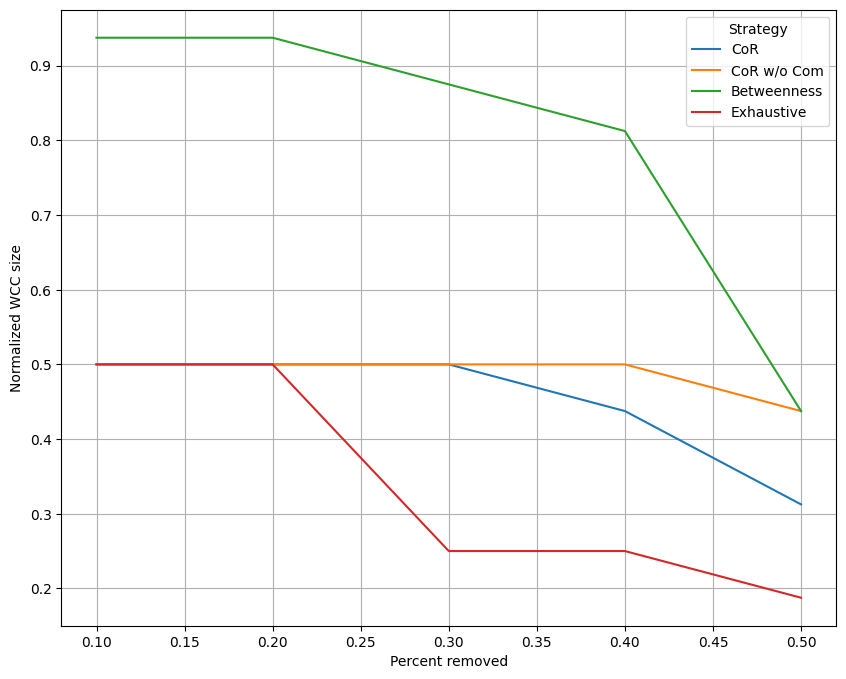

In [58]:
plt.figure(figsize=(10,8))
plt.plot(percents, total_wccs, label = "CoR")
plt.plot(percents, total_wccs_SP, label = "CoR w/o Com")
plt.plot(percents, total_wccs_bet, label = "Betweenness")
plt.plot(percents, sizes, label = "Exhaustive")
plt.ylabel("Normalized WCC size")
plt.xlabel("Percent removed")
plt.grid()
plt.legend(title= "Strategy")
plt.show()

In [ ]:
%%capture
dfs = []
for _G in graphs:
    dfs.append(calculations(_G))

In [105]:
random.seed(10)
percents = np.arange(0.01, 0.31, 0.01)
all_wccs_cities = pd.DataFrame(index = percents)
ii=0
for graph in graphs:
    randoms_wcc = pd.DataFrame(index = percents)
    for k in range(10):
        total_wccs = []
        for j in percents:
            remove = int(j*graph.number_of_edges())
            randoms_sample = random.sample(list(graph.edges), k = remove)
            H = nx.DiGraph.copy(graph)
            H.remove_edges_from(randoms_sample)
            wccs = []
            for i in nx.weakly_connected_components(H):
                wccs.append(len(i))
            total_wccs.append(max(wccs)/graph.number_of_nodes())
        randoms_wcc[str(k)] = total_wccs
    all_wccs_cities[ii] = randoms_wcc.T.mean()
    ii+=1

In [106]:
all_wccs_high = pd.DataFrame(index = percents)
ii = 0
for graph in graphs:
    total_wccs = []
    for j in percents:
        remove = int(j*graph.number_of_edges())
        topcor = dfs[ii][0].sort_values(by = "Cost", ascending = False).head(remove).index
        H = nx.DiGraph.copy(graph)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/graph.number_of_nodes())
    all_wccs_high[ii] = total_wccs
    ii+=1

In [107]:
all_wccs_bet = pd.DataFrame(index = percents)
ii = 0
for graph in graphs:
    total_wccs = []
    for j in percents:
        remove = int(j*graph.number_of_edges())
        topcor = dfs[ii][0].sort_values(by = "Betweenness", ascending = False).head(remove).index
        H = nx.DiGraph.copy(graph)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/graph.number_of_nodes())
    all_wccs_bet[ii] = total_wccs
    ii+=1

In [108]:
all_wccs_SP = pd.DataFrame(index = percents)
ii = 0
for graph in graphs:
    total_wccs = []
    for j in percents:
        remove = int(j*graph.number_of_edges())
        topcor = dfs[ii][0].sort_values(by = "SP_inverse", ascending = False).head(remove).index
        H = nx.DiGraph.copy(graph)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/graph.number_of_nodes())
    all_wccs_SP[ii] = total_wccs
    ii+=1

In [ ]:
dfs2 = pd.DataFrame()
types = ["COR", "Betwenness", "Random", "Inverse SP"]
_elist = []
_type = []
_percent = []
kk = 0
for i in percents:
    # _elist = []
    for dframes in [all_wccs_high.T, all_wccs_bet.T, all_wccs_cities.T, all_wccs_SP.T]:
        _elist = _elist + list(dframes[i])
        _percent += [i]*len(dframes)
        _type += [types[kk%4]]*len(dframes)
        kk+=1
dfs2['Value'] = _elist
dfs2["Percent"] = _percent
dfs2["Type"] = _type


fig = go.Figure()
for tipo in types:
    fig.add_trace(go.Box(x=dfs2['Percent'][dfs2['Type'] == tipo]*100,
                            y=dfs2['Value'][dfs2['Type'] == tipo],
                            name=tipo,
                            # box_visible=True,
                            # meanline_visible=True, spanmode='hard'
                            ))

fig.update_layout(
    # title="Plot Title",
    xaxis_title="Percent of edges removed",
    yaxis_title="Normalized WCC size",
    legend_title="Induced by",
    title = "Erdos-Renyi network",
    font=dict(
        family="Computer Modern Roman",
        size=18,
        color="Black"
    ),
    xaxis = dict(
        tickmode = 'array',
        tickvals = percents*100,
    ),
    # violinmode='group',
    boxmode = 'group',
    # violingap=0.001,
    width = 1960/2,
    height = 1080/2,
    margin=dict(l=20, r=20, t=50, b=20),
)

fig.show()
# fig.write_image("Results/WCCs.pdf")

# BA network

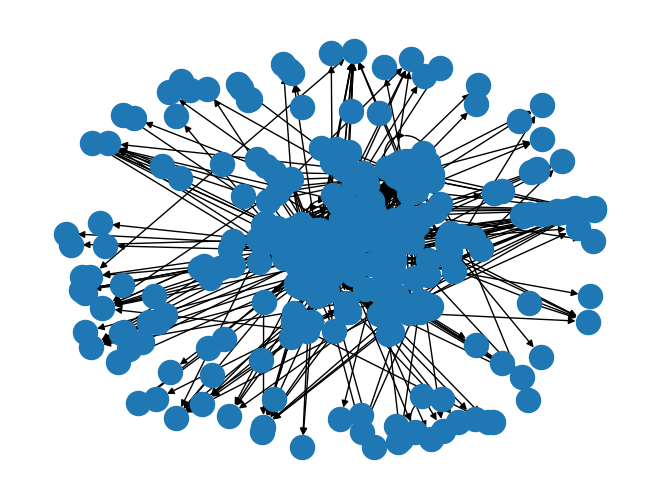

In [7]:
G = nx.DiGraph(nx.scale_free_graph(500, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None))

In [18]:
dict(G.in_degree()).values()

dict_values([22, 199, 142, 42, 1, 0, 51, 2, 0, 1, 6, 1, 23, 2, 0, 5, 11, 13, 17, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 0, 11, 0, 4, 6, 0, 11, 0, 0, 0, 9, 0, 0, 1, 8, 2, 2, 1, 0, 0, 8, 0, 1, 3, 3, 0, 0, 2, 0, 0, 0, 1, 0, 0, 4, 1, 0, 9, 1, 12, 0, 0, 0, 2, 2, 0, 0, 4, 0, 1, 0, 0, 8, 0, 0, 0, 1, 0, 8, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 1, 4, 1, 0, 4, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0, 0, 4, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 5, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

(array([350., 108.,  22.,   3.,   9.,   5.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.  ,  1.75,  3.5 ,  5.25,  7.  ,  8.75, 10.5 , 12.25, 14.  ,
        15.75, 17.5 , 19.25, 21.  , 22.75, 24.5 , 26.25, 28.  , 29.75,
        31.5 , 33.25, 35.  ]),
 <BarContainer object of 20 artists>)

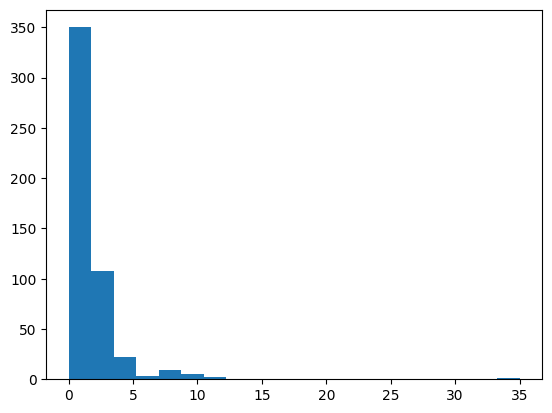

In [22]:
plt.hist(dict(G.out_degree()).values(), bins = 20)